## Setup

In [119]:
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time
np.random.seed(42)
random.seed(42)

os.getcwd()

dataset_directory = './kaggledatasets'
dataset_dfs = {}

## Neural network model

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

df_results = pd.read_csv('trainingDataMax10000.csv')

tf.random.set_seed(42)

# Presortedness metrics for full array: 'Inversions', 'Deletions', 'Runs', 'Dis'
# Presortedness metrics for sample_size = 10 distributed sampling: 'Inversions_dist', 'Deletions_dist', 'Runs_dist', 'Dis_dist'
X = df_results[['deletions_val_distStatic', 'runs_val_distStatic','arr_len']]

y = df_results['Algorithm']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# This split has been used to optimize a few parameters, can't be used to calculate final accuracy:
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_split, y_train, y_split = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, test_size=0.5, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

# indices split
print(train_indices,test_indices)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)

# neural network

def create_model(layers, layersize):
    model = Sequential()
    model.add(Dense(layersize, input_dim=3, activation='relu'))
    for i in range(layers):
        model.add(Dense(layersize, activation='relu'))
        
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model


param_grid = {
    'batch_size': [512],
    'epochs': [500],
    'layers': [6],
    'layersize': [8]
}

best_accuracy = 0
best_params = None

grid_results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    print("Training model with params:", params)
    model = create_model(layers = params['layers'], layersize = params['layersize'])
    model.fit(X_train_scaled, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    y_pred = model.predict(X_val_scaled)
    accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    grid_results.append({
        'Layers': params['layers'],
        'Layer Size': params['layersize'],
        'Accuracy': accuracy
    })
    print("Accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

df_grid_results = pd.DataFrame(grid_results)
df_grid_results_sorted = df_grid_results.sort_values(by='Accuracy', ascending=False)
print(df_grid_results_sorted)

# Print best parameters and accuracy
print("Best validation parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
print("\n")

baccuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

Index([ 287,  922,  755,   86, 1531, 1188, 1599,  990,   54, 1268,
       ...
        466,  121, 1638, 1044, 1095, 1130, 1294,  860, 1459, 1126],
      dtype='int64', length=1183) Index([ 168,  497, 1464, 1669,   81, 1067,  490, 1089,  744, 1124,
       ...
       1049,  483,  426,  292,  351, 1314,   99, 1672,  554, 1292],
      dtype='int64', length=254)
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 6, 'layersize': 8}


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 0.8932806253433228
   Layers  Layer Size  Accuracy
0       6           8  0.893281
Best validation parameters: {'batch_size': 512, 'epochs': 500, 'layers': 6, 'layersize': 8}
Best validation accuracy: 0.8932806253433228


Test Accuracy: 0.9330708384513855


In [121]:
import pickle

# Save the dictionary to a file
with open('df_grid_results_dynamic.pkl', 'wb') as f:
    pickle.dump(df_grid_results, f)

## Results

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Time to predict the test set: 0.2969956398010254
size of test set: 254
number of missclassifications: 17
    Unnamed: 0                    Dataset  \
0          148             KernelVersions   
1         1678       colombo_rh_2012-2018   
2         1573                          X   
3         1156  final_filled_startup_data   
4          968                data_result   
5         1030                  pandemics   
6          123               wage_predict   
7          889                data_result   
8         1293                      Clean   
9         1310                   Original   
10        1096            timesMergedData   
11         584                       smmh   
12         534                    milknew   
13        1301                      Clean   
14         679          train_pixel_stats   
15        1210               preeclampsia   
16         184      dehiwala_rf_2012-2018   

                                             

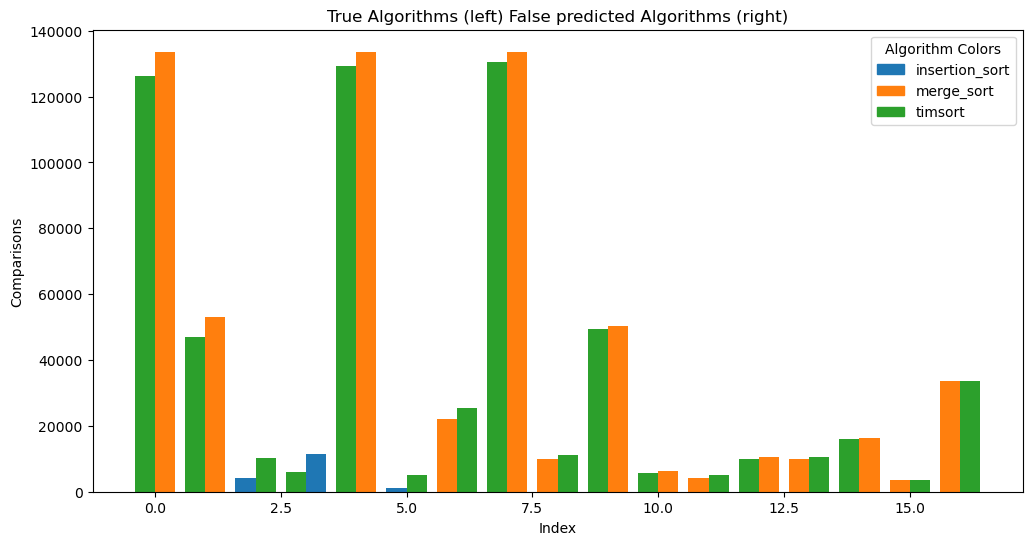

In [122]:
start_time = time.time()

y_pred_all = best_model.predict(X_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

print("Time to predict the test set: " + str(elapsed_time))

y_pred_all_classes = np.argmax(y_pred_all, axis=1)
predicted_algorithms_all = label_encoder.inverse_transform(y_pred_all_classes)

df_results["y_pred"] = predicted_algorithms_all

test_set_df = df_results.iloc[test_indices]
test_set_df.reset_index(drop=True, inplace=True)

print("size of test set: " + str(len(test_set_df)))

missclassified_df = test_set_df[test_set_df["Algorithm"] != test_set_df["y_pred"]].copy()

missclassified_df.reset_index(drop=True, inplace=True)

print("number of missclassifications: " + str(len(missclassified_df)))

missclassified_df["f"] = missclassified_df.apply(lambda row: row[row["y_pred"]], axis=1)
missclassified_df["t"] = missclassified_df.apply(lambda row: row[row["Algorithm"]], axis=1)

missclassified_df["abs_diff"] = missclassified_df["f"] - missclassified_df["t"]

# Sort by absolute difference in descending order
missclassified_df = missclassified_df.sort_values(by="abs_diff", ascending=False).reset_index(drop=True)
print(missclassified_df)

unique_algorithms = list(set(missclassified_df["Algorithm"].unique()) | set(missclassified_df["y_pred"].unique()))
palette = sns.color_palette("tab10", len(unique_algorithms))
color_map = dict(zip(unique_algorithms, palette))

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(missclassified_df.index - 0.2, missclassified_df["t"], width=0.4, 
       color=[color_map[alg] for alg in missclassified_df["Algorithm"]])

ax.bar(missclassified_df.index + 0.2, missclassified_df["f"], width=0.4, 
       color=[color_map[alg] for alg in missclassified_df["y_pred"]])

legend_patches = [mpatches.Patch(color=color_map[alg], label=alg) for alg in unique_algorithms]

ax.legend(handles=legend_patches, title="Algorithm Colors", loc="upper right")

ax.set_xlabel("Index")
ax.set_ylabel("Comparisons")
ax.set_title("True Algorithms (left) False predicted Algorithms (right)")

plt.show()

In [123]:
actual_counts = test_set_df["Algorithm"].value_counts()
predicted_counts = test_set_df["y_pred"].value_counts()

summary_table = pd.DataFrame({
    "Actual Count": actual_counts,
    "Predicted Count": predicted_counts
})

print(summary_table)

                Actual Count  Predicted Count
merge_sort               180              182
timsort                   52               51
insertion_sort            22               21


[155   6 164  60 113 182 198 248   9 118 175 217 219 139  67 225 195  15
 120  24 241  19 115  68 177]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29980\2618560127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_20["f"] = test_df_20.apply(lambda row: row[row["y_pred"]], axis=1)


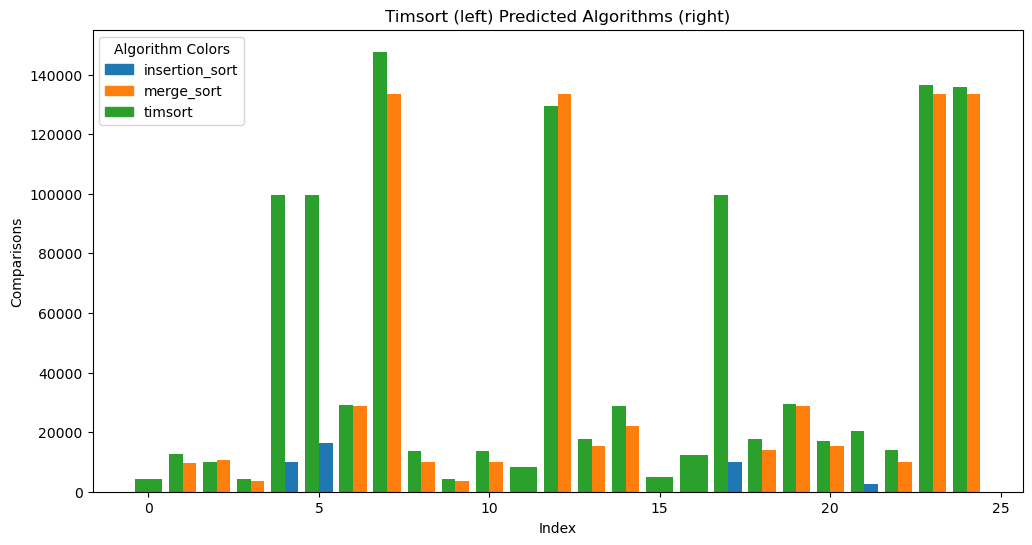

In [124]:
random_index = np.random.choice(range(251), 25, replace=False)
print(random_index)

test_df_20 = test_set_df.iloc[random_index]
test_df_20.reset_index(drop=True, inplace=True)

test_df_20["f"] = test_df_20.apply(lambda row: row[row["y_pred"]], axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(test_df_20.index - 0.2, test_df_20["timsort"], width=0.4, 
       color=[color_map["timsort"]])

ax.bar(test_df_20.index + 0.2, test_df_20["f"], width=0.4, 
       color=[color_map[alg] for alg in test_df_20["y_pred"]])

legend_patches = [mpatches.Patch(color=color_map[alg], label=alg) for alg in unique_algorithms]

ax.legend(handles=legend_patches, title="Algorithm Colors", loc="upper left")

ax.set_xlabel("Index")
ax.set_ylabel("Comparisons")
ax.set_title("Timsort (left) Predicted Algorithms (right)")

plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29980\2705915276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_df["difference"] = np.abs(test_set_df["timsort"] - test_set_df.apply(lambda row: row[row["y_pred"]], axis=1))


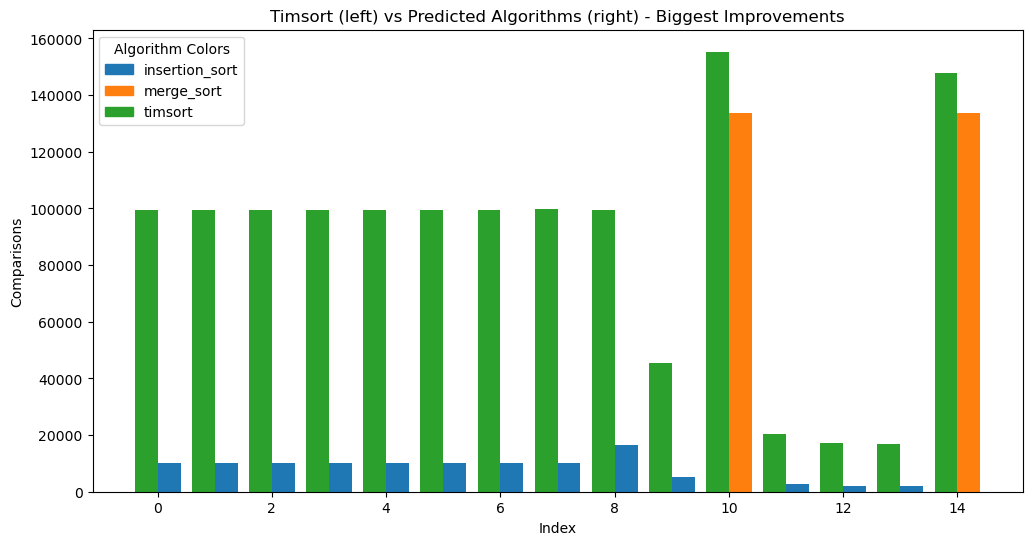

In [125]:
# Calculate absolute difference between "y_pred" column and "timsort"
test_set_df["difference"] = np.abs(test_set_df["timsort"] - test_set_df.apply(lambda row: row[row["y_pred"]], axis=1))

# Select the 20 rows with the largest difference
test_df_15 = test_set_df.nlargest(15, "difference").copy()  # Copy to avoid SettingWithCopyWarning
test_df_15.reset_index(drop=True, inplace=True)

# Drop the temporary "difference" column as it's no longer needed
test_df_15.drop(columns=["difference"], inplace=True)

# Extract values for plotting
test_df_15["f"] = test_df_15.apply(lambda row: row[row["y_pred"]], axis=1)

# Define color mapping for algorithms
#unique_algorithms = list(set(test_set_df["Algorithm"].unique()) | set(test_set_df["y_pred"].unique()) | {"timsort"})
#palette = sns.color_palette("tab10", len(unique_algorithms))
#color_map = dict(zip(unique_algorithms, palette))

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot "timsort" values in a single color
ax.bar(test_df_15.index - 0.2, test_df_15["timsort"], width=0.4, color=[color_map["timsort"]])

# Plot "f" values (predicted algorithm) with corresponding colors
ax.bar(test_df_15.index + 0.2, test_df_15["f"], width=0.4, 
       color=[color_map[alg] for alg in test_df_15["y_pred"]])

# Create legend
legend_patches = [mpatches.Patch(color=color_map[alg], label=alg) for alg in unique_algorithms]
ax.legend(handles=legend_patches, title="Algorithm Colors", loc="upper left")

# Labels and title
ax.set_xlabel("Index")
ax.set_ylabel("Comparisons")
ax.set_title("Timsort (left) vs Predicted Algorithms (right) - Biggest Improvements")

# Show plot
plt.show()

In [126]:
# Make predictions on the test data and compare them to the True best Algorithm
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
predicted_algorithms = label_encoder.inverse_transform(y_pred_classes)
true_algorithms = label_encoder.inverse_transform(y_test)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
comparison_df = pd.DataFrame({'Predicted Algorithm': predicted_algorithms, 'True Algorithm': true_algorithms})
display(comparison_df.head(50))

accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Predicted Algorithm,True Algorithm
0,merge_sort,merge_sort
1,merge_sort,merge_sort
2,merge_sort,merge_sort
3,merge_sort,merge_sort
4,merge_sort,merge_sort
5,timsort,timsort
6,merge_sort,merge_sort
7,timsort,timsort
8,timsort,timsort
9,merge_sort,merge_sort


Test Accuracy: 0.9330708384513855


### GRIDSEARCH SAMPLESIZE 13 RUNS(X) REM(X)

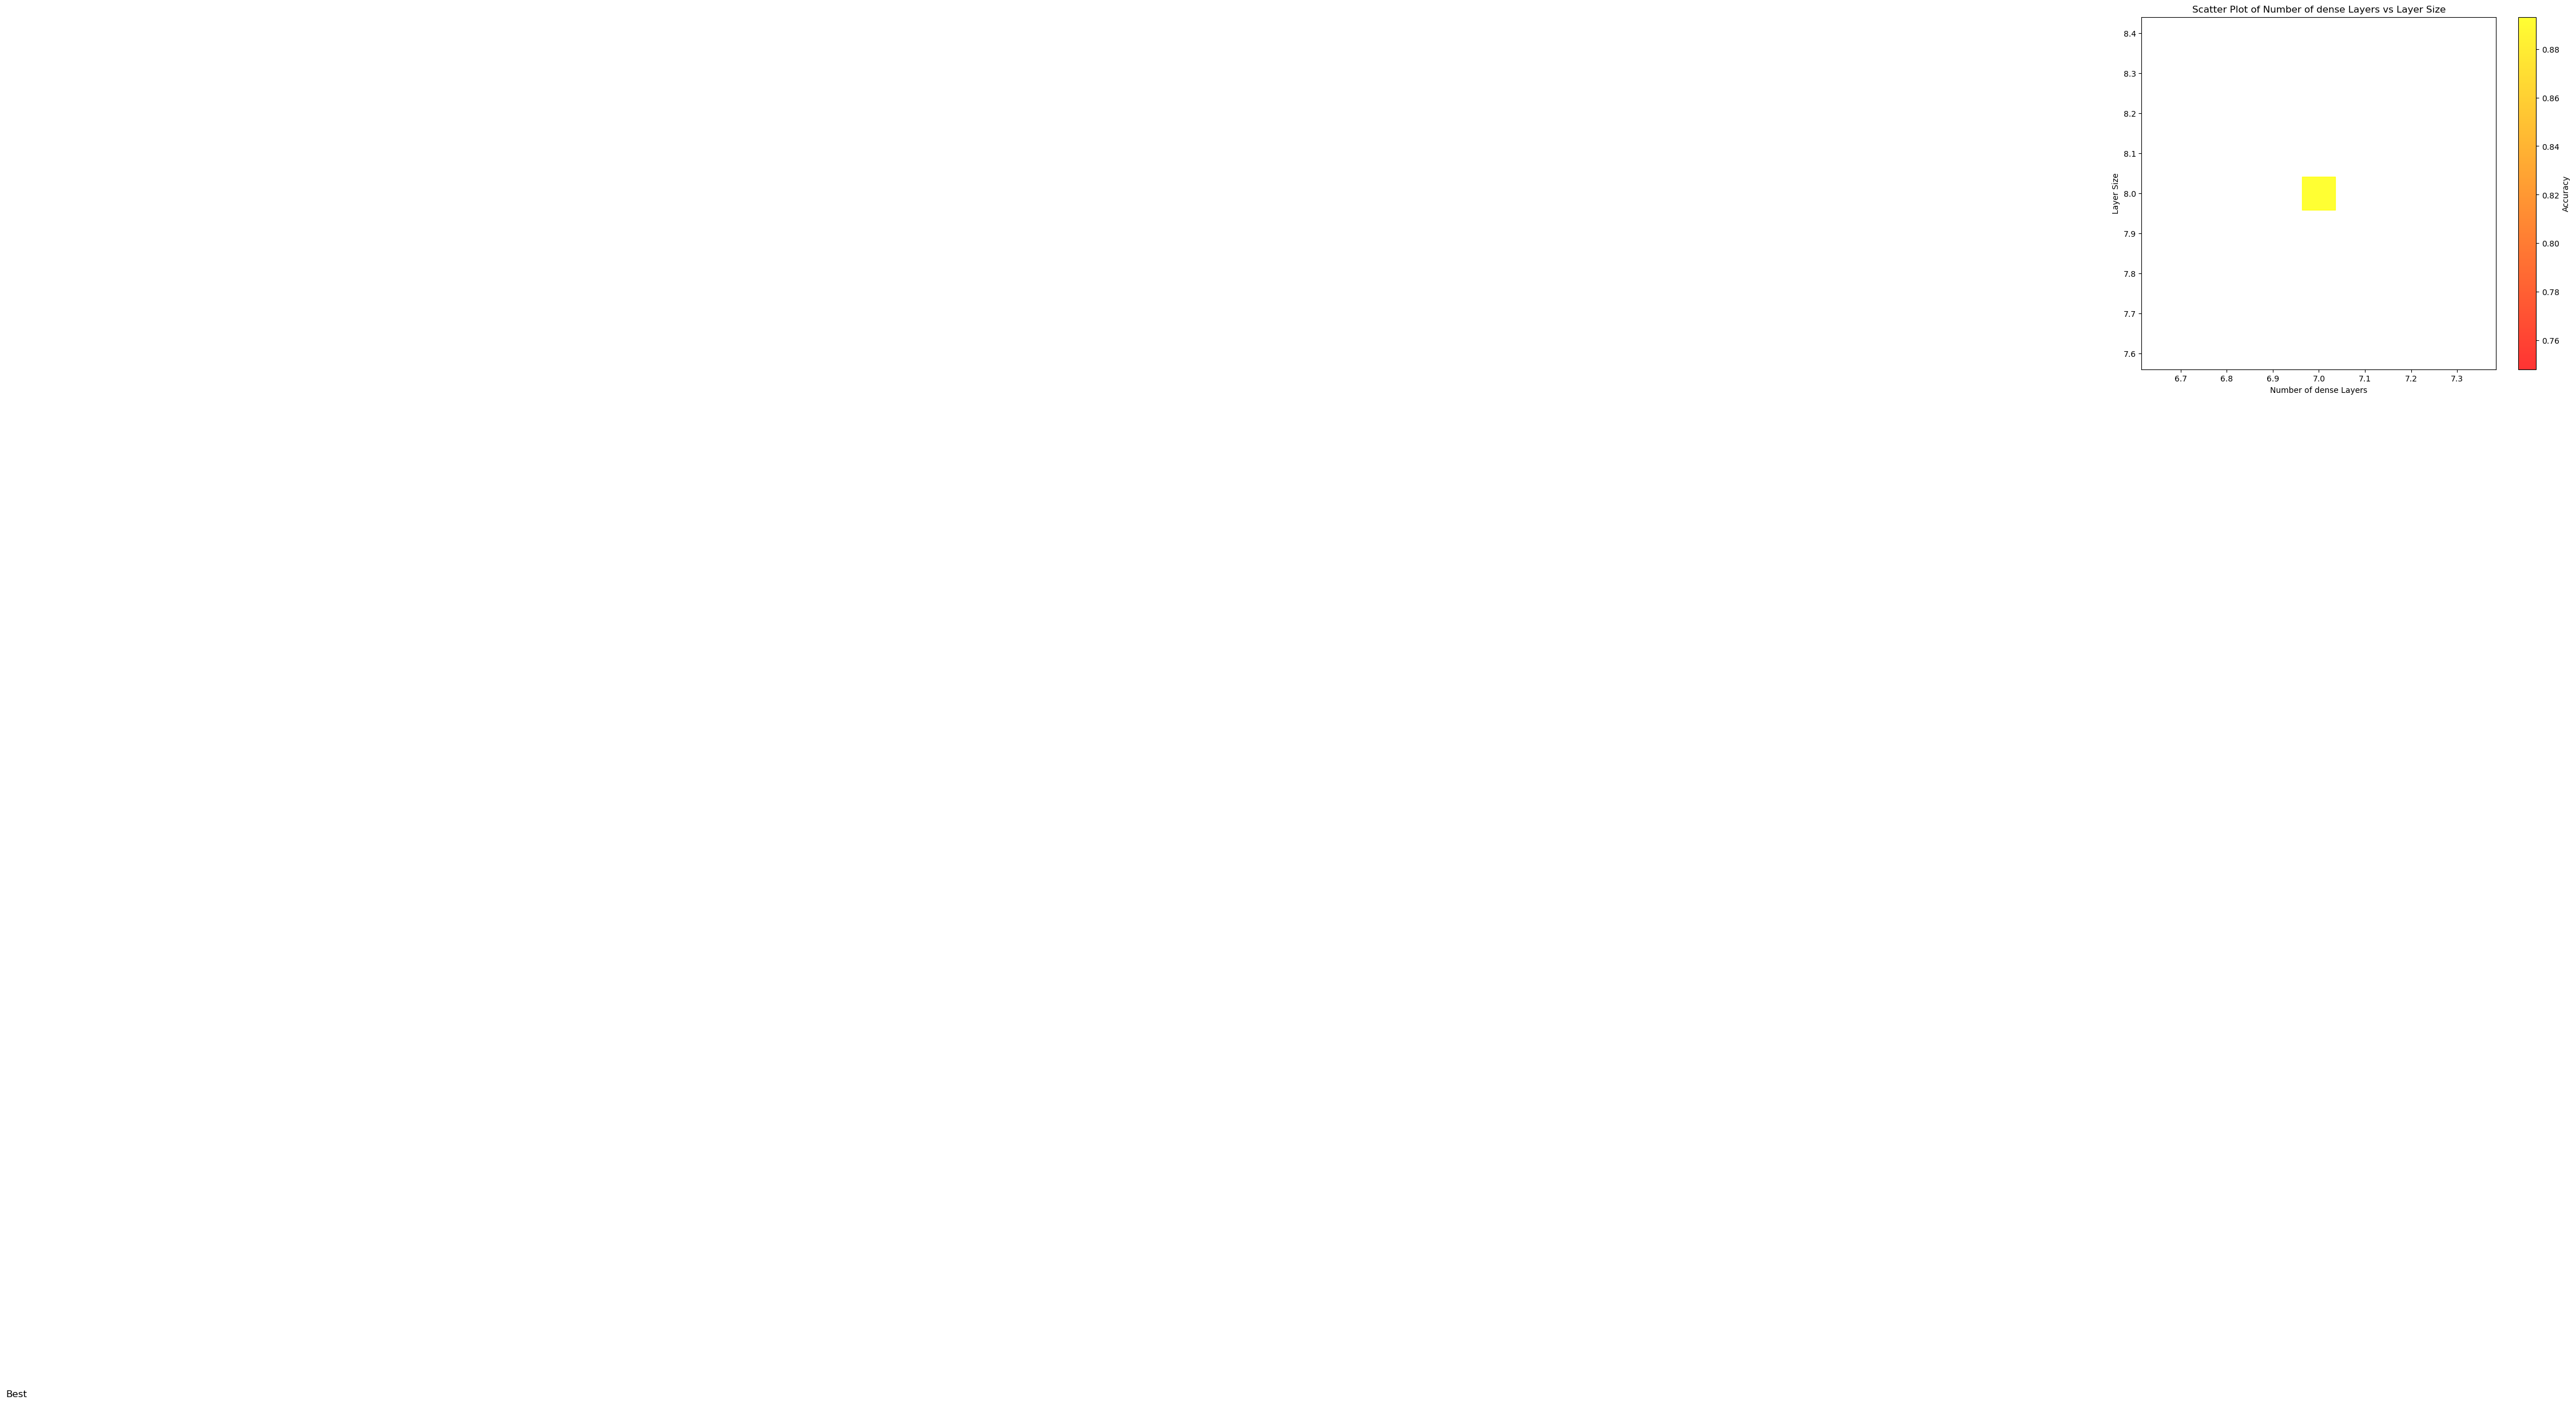

In [127]:
import pickle

with open('df_grid_results_dynamic.pkl', 'rb') as f:
    df_grid_results = pickle.load(f)

# Create scatter plot
plt.figure(figsize=(10, 8))
vmax = df_grid_results['Accuracy'].max()
plt.scatter(df_grid_results['Layers']+1, df_grid_results['Layer Size'], c=df_grid_results['Accuracy'], cmap='autumn', alpha=0.8, vmax=vmax, vmin=0.748, s=1800, marker = 's')

# Add color bar
plt.colorbar(label='Accuracy')

plt.text(2, 5, 'Best', color='black', fontsize=12, ha='center', va='center')

# Set labels and title
plt.xlabel('Number of dense Layers')
plt.ylabel('Layer Size')
plt.title('Scatter Plot of Number of dense Layers vs Layer Size')

# Show plot
plt.show()

### Average Comparisons

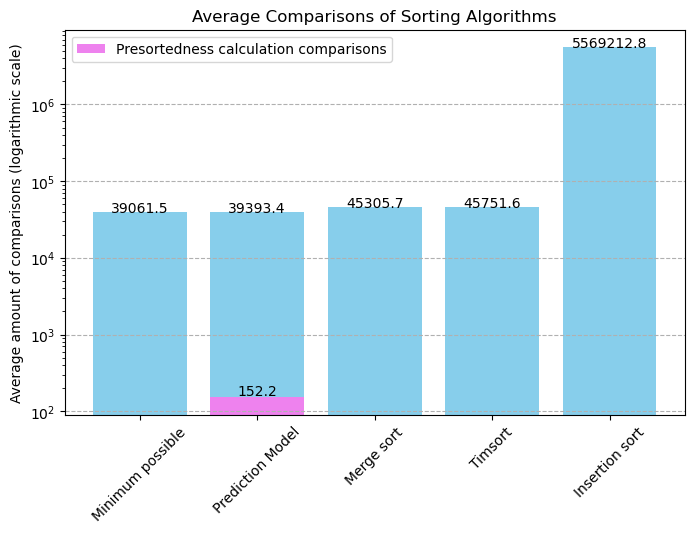

Minimum possible:  39061.5
Algorithm predicting model:  39241.2
Presortedness calculation comparisons:  152.2
Combined comparisons model:  39393.4
'sort_comparisons':  39241.2
'presortedness_comparisons':  152.2
'combined':  39393.4


Merge sort:  45305.7
Timsort:  45751.6
Introsort:  1000000000.0
Quick sort:  1000000000.0
Insertion sort:  5569212.8
Selection sort:  1000000000.0


In [128]:
test_set_df = df_results.iloc[test_indices]
test_set_df.reset_index(drop=True, inplace=True)

c = []
t = []

for index, row in test_set_df.iterrows():
    c.append(row[predicted_algorithms[index]])
    t.append(row[true_algorithms[index]])

def calculate_average(column_name):
    return round(np.sum(test_set_df[column_name]) / len(test_set_df), 1)

minimum_possible = round(np.sum(t)/len(test_set_df), 1)
algorithm_prediction_model = round(np.sum(c)/len(test_set_df), 1)

#inv_dis_comp_dist_avg = calculate_average('inv_dis_comp')

deletions_comp_dist_avg = calculate_average('deletions_comp_distStatic')
runs_comp_dist_avg = calculate_average('runs_comp_distStatic')

# 
presortedness_average_comp = runs_comp_dist_avg + deletions_comp_dist_avg

merge_sort_avg = calculate_average('merge_sort')
timsort_avg = calculate_average('timsort')
introsort_avg = calculate_average('introsort')
quick_sort_avg = calculate_average('quick_sort')
insertion_sort_avg = calculate_average('insertion_sort')
selection_sort_avg = calculate_average('selection_sort')



data = {
    'Algorithm': ['Minimum possible', 'Prediction Model', 'Merge sort', 'Timsort', 'Insertion sort'],
    'Average Value': [minimum_possible, round(algorithm_prediction_model + presortedness_average_comp, 1), merge_sort_avg, timsort_avg, insertion_sort_avg]
}
df_average_comp = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 5))

plt.bar(df_average_comp['Algorithm'], df_average_comp['Average Value'], color='skyblue')
plt.bar(df_average_comp['Algorithm'], [0, presortedness_average_comp, 0, 0, 0] , color='violet', label = 'Presortedness calculation comparisons')


plt.title('Average Comparisons of Sorting Algorithms')

for i, val in enumerate(df_average_comp['Average Value']):
    plt.text(i, val + 100, str(val), ha='center')

plt.text(1, presortedness_average_comp + 10, str(presortedness_average_comp), ha='center')
#plt.text(1, algorithm_prediction_model - 1000, str(algorithm_prediction_model), ha='center')

plt.ylabel('Average amount of comparisons (logarithmic scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

print('Minimum possible: ', minimum_possible)
print('Algorithm predicting model: ', algorithm_prediction_model)
print('Presortedness calculation comparisons: ', presortedness_average_comp)
print('Combined comparisons model: ', round(algorithm_prediction_model + presortedness_average_comp, 1))

print('\'sort_comparisons\': ', algorithm_prediction_model)
print('\'presortedness_comparisons\': ', presortedness_average_comp)
print('\'combined\': ', round(algorithm_prediction_model + presortedness_average_comp, 1))

print('\n')
print('Merge sort: ', merge_sort_avg)
print('Timsort: ', timsort_avg)
print('Introsort: ', introsort_avg)
print('Quick sort: ', quick_sort_avg)
print('Insertion sort: ', insertion_sort_avg)
print('Selection sort: ', selection_sort_avg)

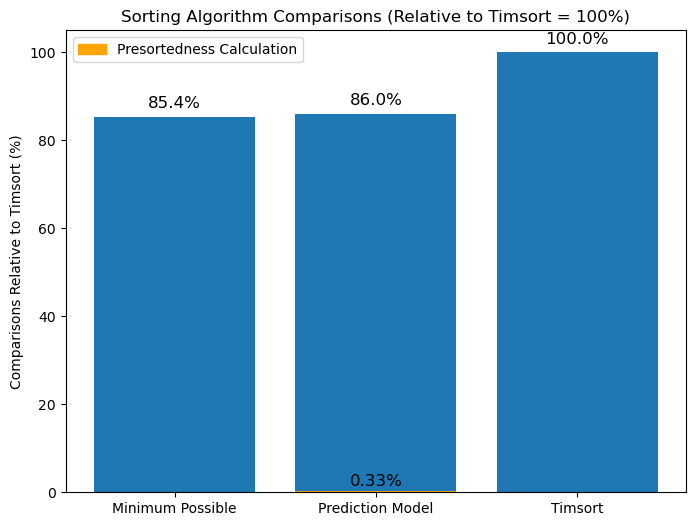

In [129]:
timsort_value = 45751.6  # 100%
prediction_model_value = 39365  # Main prediction value
presortedness_value = 152.2  # Small bottom bar for presortedness calculation
minimum_possible_value = 39061.5  # Minimum comparisons

# Compute relative percentages
timsort_percentage = 100  # Reference point
prediction_percentage = (prediction_model_value / timsort_value) * 100  # Relative to Timsort
presortedness_percentage = (presortedness_value / timsort_value) * 100  # Small fraction
minimum_percentage = (minimum_possible_value / timsort_value) * 100  # Relative to Timsort

# Define labels and colors
bar_labels = ["Minimum Possible", "Prediction Model", "Timsort"]
main_bar_values = [minimum_percentage, prediction_percentage, timsort_percentage]
bottom_bar_values = [0, presortedness_percentage, 0]  # Only applied to Prediction Model

colors_bottom = ["none", "orange", "none"]  # Orange for presortedness calc

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot main bars
bars_main = ax.bar(bar_labels, main_bar_values)

# Plot presortedness calculation as a small bottom section in the "Prediction Model" bar
bars_bottom = ax.bar(bar_labels, bottom_bar_values, color=colors_bottom)

ax.set_ylabel("Comparisons Relative to Timsort (%)")
ax.set_title("Sorting Algorithm Comparisons (Relative to Timsort = 100%)")

for bar, value in zip(bars_main, main_bar_values):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 2, f"{value:.1f}%", ha="center", fontsize=12)

ax.text(bars_bottom[1].get_x() + bars_bottom[1].get_width() / 2, presortedness_percentage + 1,  
        f"{presortedness_percentage:.2f}%", ha="center", fontsize=12, color="black")

legend_patch = mpatches.Patch(color="orange", label="Presortedness Calculation")
ax.legend(handles=[legend_patch], loc="upper left")

# Show plot
plt.show()

### Sample size Analysis (rem(X), runs(X))

with param_grid: 
{'batch_size': [512], 'epochs': [500], 'layers': [4, 6, 8], 'layersize': [4, 6, 8]}


,accuracy,sort_comparisons,presortedness_comparisons,combined
0,0.8600,21708.6,136.5,21845.1
1,0.8600,21708.6,140.9,21849.5
2,0.8600,21708.6,145.3,21853.9
3,0.6319,21708.6,149.7,21858.3
4,0.6319,21708.6,154.2,21862.8
5,0.6319,19274.6,159.1,19433.7
6,0.6319,20130.3,163.6,20293.9
7,0.7139,20099.5,168.3,20267.8
8,0.5986,20099.5,172.6,20272.1
9,0.8600,20099.5,177.1,20276.6


number of sequences:  1156


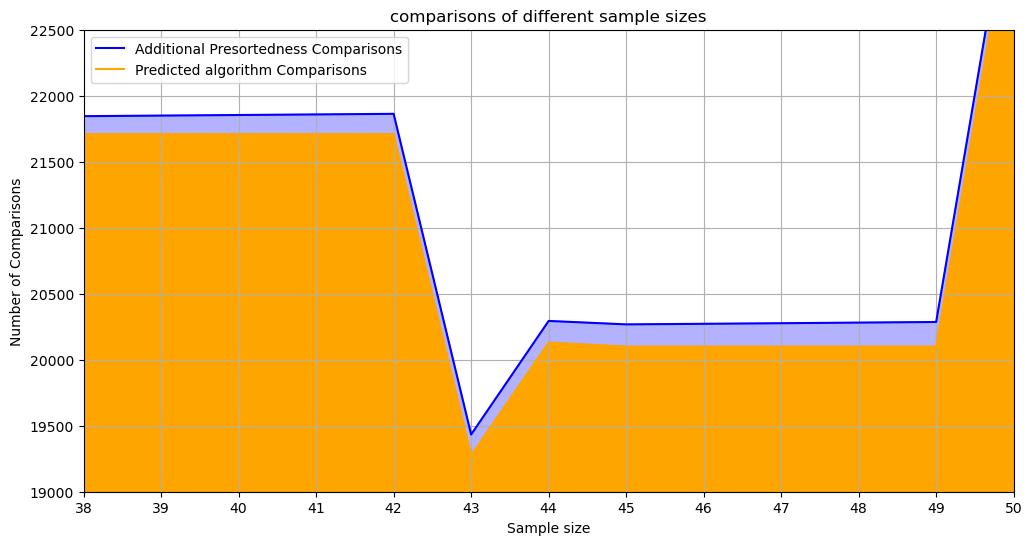

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    {
        'accuracy': 0.86,
        'sort_comparisons':  21708.6,
        'presortedness_comparisons':  136.5,
        'combined':  21845.1
    },
    {
        'accuracy': 0.86,
        'sort_comparisons':  21708.6,
        'presortedness_comparisons':  140.9,
        'combined':  21849.5
    },
    {
        'accuracy': 0.86,
        'sort_comparisons':  21708.6,
        'presortedness_comparisons':  145.3,
        'combined':  21853.9
    },
    {
        'accuracy': 0.6319,
        'sort_comparisons':  21708.6,
        'presortedness_comparisons':  149.7,
        'combined':  21858.3
    },
    {
        'accuracy': 0.6319,
        'sort_comparisons':  21708.6,
        'presortedness_comparisons':  154.2,
        'combined':  21862.8
    },
    {
        'accuracy': 0.6319,
        'sort_comparisons':  19274.6,
        'presortedness_comparisons':  159.1,
        'combined':  19433.7
    },
    {
        'accuracy': 0.6319,
        'sort_comparisons':  20130.3,
        'presortedness_comparisons':  163.6,
        'combined':  20293.9
    },
    {
        'accuracy': 0.7139,
        'sort_comparisons':  20099.5,
        'presortedness_comparisons':  168.3,
        'combined':  20267.8
    },
    {
        'accuracy': 0.5986,
        'sort_comparisons':  20099.5,
        'presortedness_comparisons':  172.6,
        'combined':  20272.1
    },
    {
        'accuracy': 0.86,
        'sort_comparisons':  20099.5,
        'presortedness_comparisons':  177.1,
        'combined':  20276.6
    },
    {
        'accuracy': 0.86,
        'sort_comparisons':  20099.5,
        'presortedness_comparisons':  181.8,
        'combined':  20281.3
    },
    {
        'accuracy': 0.86,
        'sort_comparisons':  20099.5,
        'presortedness_comparisons':  186.4,
        'combined':  20285.9
    },
    {
        'accuracy': 0.5986,
        'sort_comparisons':  23550.1,
        'presortedness_comparisons':  191.0,
        'combined':  23741.1
    },
]

# Create the DataFrame
df = pd.DataFrame(data)

param_grid = {
    'batch_size': [512],
    'epochs': [500],
    'layers': [4,6,8],
    'layersize': [4,6,8]
}

print("with param_grid: ")
print(param_grid)

# Display the DataFrame
display(df)

print('number of sequences: ', 1156)

# Plotting
plt.figure(figsize=(12, 6))

# Density plot for 'combined'
plt.plot(df.index + 1, df['combined'], label='Additional Presortedness Comparisons', color='blue')
plt.fill_between(df.index + 1, df['combined'], color='blue', alpha=0.3)

# Density plot for 'presortedness_comparisons'
plt.plot(df.index + 1, df['combined'] - df['presortedness_comparisons'], label='Predicted algorithm Comparisons', color='orange')
plt.fill_between(df.index + 1, df['combined'] - df['presortedness_comparisons'], color='orange')

# Labels and legend
plt.grid()
plt.ylim(19000,22500)
plt.xlim(1,9)

custom_labels = [38,39,40,41,42,43,44,45,46,47,48,49,50]

plt.xticks(range(1, 14), labels = custom_labels)

plt.xlabel('Sample size')
plt.ylabel('Number of Comparisons')
plt.title('comparisons of different sample sizes')
plt.legend()

# Show plot
plt.show()

### Presortedness combinations table

In [131]:
data = [
    {
        'presortedness_combinations': 'inv_dis',
        'accuracy': 0.6851,
        'sort_comparisons': 1316.8,
        'presortedness_comparisons': 45,
        'combined': 1361.8
    },
    {
        'presortedness_combinations': 'runs_rem',
        'accuracy': 0.6917,
        'sort_comparisons': 1313.3,
        'presortedness_comparisons': 26.1,
        'combined': 1339.4
    },
    {
        'presortedness_combinations': 'inv_dis_runs',
        'accuracy': 0.7161,
        'sort_comparisons': 1310.5,
        'presortedness_comparisons': 54.0,
        'combined': 1364.5
    },
    {
        'presortedness_combinations': 'inv_dis_rem',
        'accuracy': 0.6917,
        'sort_comparisons': 1312.7,
        'presortedness_comparisons': 62.1,
        'combined': 1374.8
    },
    {
        'presortedness_combinations': 'inv_dis_runs_rem',
        'accuracy': 0.7228,
        'sort_comparisons': 1306.4,
        'presortedness_comparisons': 71.1,
        'combined': 1377.5
    },
    # Add more dictionaries as needed
]

# Create the DataFrame
df = pd.DataFrame(data)

param_grid = {
    'batch_size': [250,500],
    'epochs': [250,500],
    'layers': [4,8],
    'layersize': [16, 64]
}

print("with param_grid: ")
print(param_grid)

# Display the DataFrame
display(df)

with param_grid: 
{'batch_size': [250, 500], 'epochs': [250, 500], 'layers': [4, 8], 'layersize': [16, 64]}


,presortedness_combinations,accuracy,sort_comparisons,presortedness_comparisons,combined
0,inv_dis,0.6851,1316.8,45.0,1361.8
1,runs_rem,0.6917,1313.3,26.1,1339.4
2,inv_dis_runs,0.7161,1310.5,54.0,1364.5
3,inv_dis_rem,0.6917,1312.7,62.1,1374.8
4,inv_dis_runs_rem,0.7228,1306.4,71.1,1377.5


### Model analysis

In [132]:
"""from itertools import product

# Generate arrays with combinations of values
def generate_arrays(values, n):
    return [list(comb) for comb in product(values, repeat=n)]

possible_values = [100, 25, 10 , 5, 1, 0]
X_analysis = generate_arrays(possible_values, 2)

X_analysis_scaled = scaler.fit_transform(X_analysis)

y_preds = model.predict(X_analysis_scaled)
y_preds_classes = np.argmax(y_preds, axis=1)
predicted_algorithm = label_encoder.inverse_transform(y_preds_classes)

print(predicted_algorithm)"""

'from itertools import product\n\n# Generate arrays with combinations of values\ndef generate_arrays(values, n):\n    return [list(comb) for comb in product(values, repeat=n)]\n\npossible_values = [100, 25, 10 , 5, 1, 0]\nX_analysis = generate_arrays(possible_values, 2)\n\nX_analysis_scaled = scaler.fit_transform(X_analysis)\n\ny_preds = model.predict(X_analysis_scaled)\ny_preds_classes = np.argmax(y_preds, axis=1)\npredicted_algorithm = label_encoder.inverse_transform(y_preds_classes)\n\nprint(predicted_algorithm)'